In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import missingno as msno

%matplotlib inline

## Load the data

Here, we are interested in different indicators to determine if a country has high/low HDI. We first load all these indicators into a dataframe called data.

For more information, see ND-Gain website https://gain.nd.edu/our-work/country-index/. The explanation about each indicator can be found at 'ND-GAIN Country Index Codebook.pdf'

In [131]:
del data
indicators = listdir('resources/indicators/')
for f in indicators:
    temp = pd.read_csv(f'resources/indicators/{f}/score.csv')
    temp = temp.melt(id_vars=['ISO3','Name'],
          var_name='Date',
          value_name='Value_'+f)
    try: data
    except NameError: data = temp.copy()
    else: data = data.merge(temp.drop(['Name'],axis=1),on=['ISO3','Date'],how='left')
    data = data.sort_values(by=['Name','Date'])

In [132]:
data.head()

,ISO3,Name,Date,Value_gdp,Value_hdi,Value_id_econ_01,Value_id_ecos_01,Value_id_ecos_02,Value_id_ecos_03,Value_id_ecos_04,...,Value_id_soci_02,Value_id_soci_03,Value_id_soci_04,Value_id_wate_01,Value_id_wate_02,Value_id_wate_03,Value_id_wate_04,Value_id_wate_05,Value_id_wate_06,Value_pop
0,AFG,Afghanistan,1995,877.014268,0.331,0.496497,0.658824,0.0,NaN,0.201168,...,0.179672,0.006783,NaN,0.44196,0.179415,0.373038,0.287226,0.974335,0.911985,18110662
1,AFG,Afghanistan,1996,877.014268,0.335,0.496497,0.658824,0.0,NaN,0.201168,...,0.179666,0.006783,NaN,0.44196,0.179415,0.373038,0.287226,0.974335,0.911985,18853444
2,AFG,Afghanistan,1997,877.014268,0.339,0.496497,0.658824,0.0,NaN,0.201168,...,0.179662,0.006783,NaN,0.44196,0.179415,0.373038,0.287226,0.974335,0.911985,19357126
3,AFG,Afghanistan,1998,877.014268,0.344,0.496497,0.658824,0.0,NaN,0.201168,...,0.179661,0.006783,NaN,0.44196,0.179415,0.371146,0.287226,0.975071,0.911985,19737770
4,AFG,Afghanistan,1999,877.014268,0.348,0.496497,0.658824,0.0,NaN,0.201168,...,0.179658,0.006783,NaN,0.44196,0.179415,0.369254,0.287226,0.975808,0.911985,20170847


The first thing we notice when looking at the data is that some countries are missing some indicators, we can look more carefully for the missing data

<AxesSubplot: >

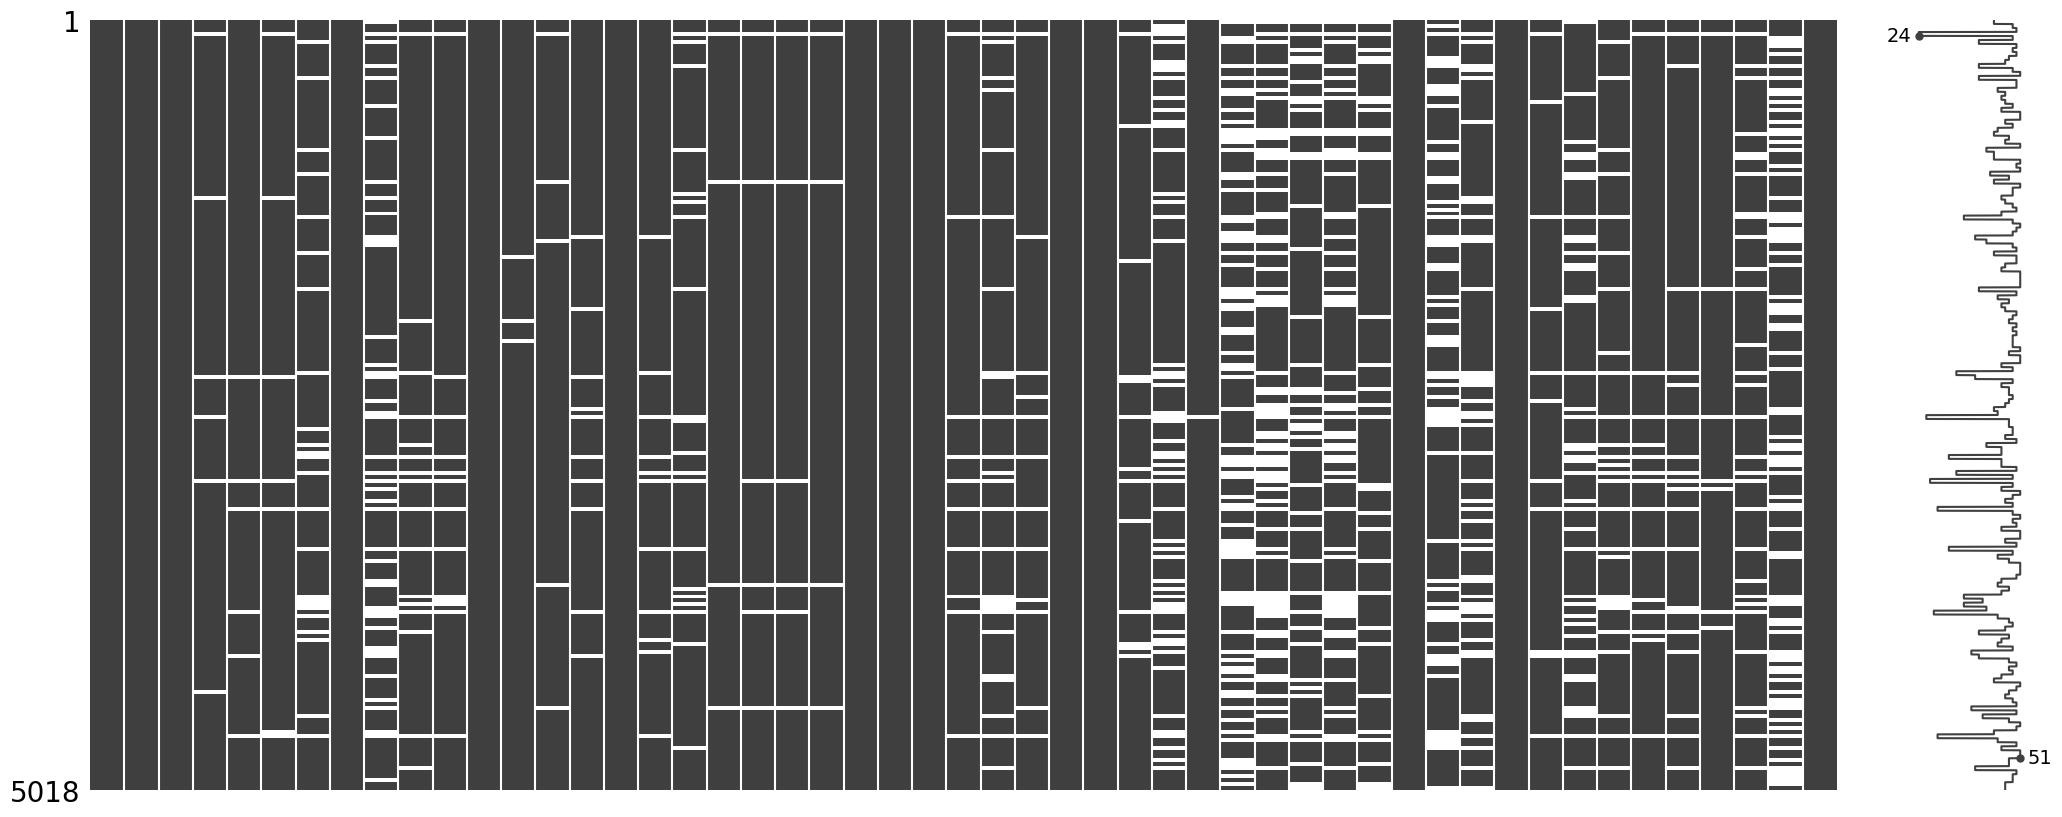

In [205]:
msno.matrix(data)

Because some of the columns have much of their data missing if we were to drop the rows with missing values we would end up throwing much of our data. 

To avoid this issue, we can consider only the columns with missing data accounting for less than $10\%$, then we drop the rows with missing values.

In [134]:
filled_columns = [name for (name,val) in data.isna().mean().reset_index().values if val<0.1]
clean_data = data[filled_columns].dropna()

Now we can classify countries as 'Developed' based on International Monetary Fund (IMF) classification, see https://www.imf.org/external/pubs/ft/weo/2022/01/weodata/groups.htm#ae. This is not a unique way to classify if a country is developed. Another way used by United Nations (UN) is to consider HDI larger than 0.8

In [135]:
dev_countries = ['Andorra','Australia','Austria','Belgium','Canada','Cyprus','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hong Kong SAR','Iceland','Ireland','Israel','Italy','Japan','Korea','Latvia','Lithuania','Luxembourg','Macao SAR','Malta','Netherlands','New Zealand','Norway','Portugal','Puerto Rico','San Marino','Singapore','Slovak Republic','Slovenia','Spain','Sweden','Switzerland','Taiwan Province of China','United Kingdom','United States']
mask  = clean_data['Name'].isin(dev_countries)
clean_data.loc[mask,'Developed'] = 1
clean_data['Developed'] = clean_data['Developed'].fillna(0)

#mask = clean_data['Value_hdi']>0.8
#clean_data.loc[mask,'Developed'] = 1
#clean_data['Developed'] = clean_data['Developed'].fillna(0)

Before we start, we can look at the correlation between different indicators

<AxesSubplot: >

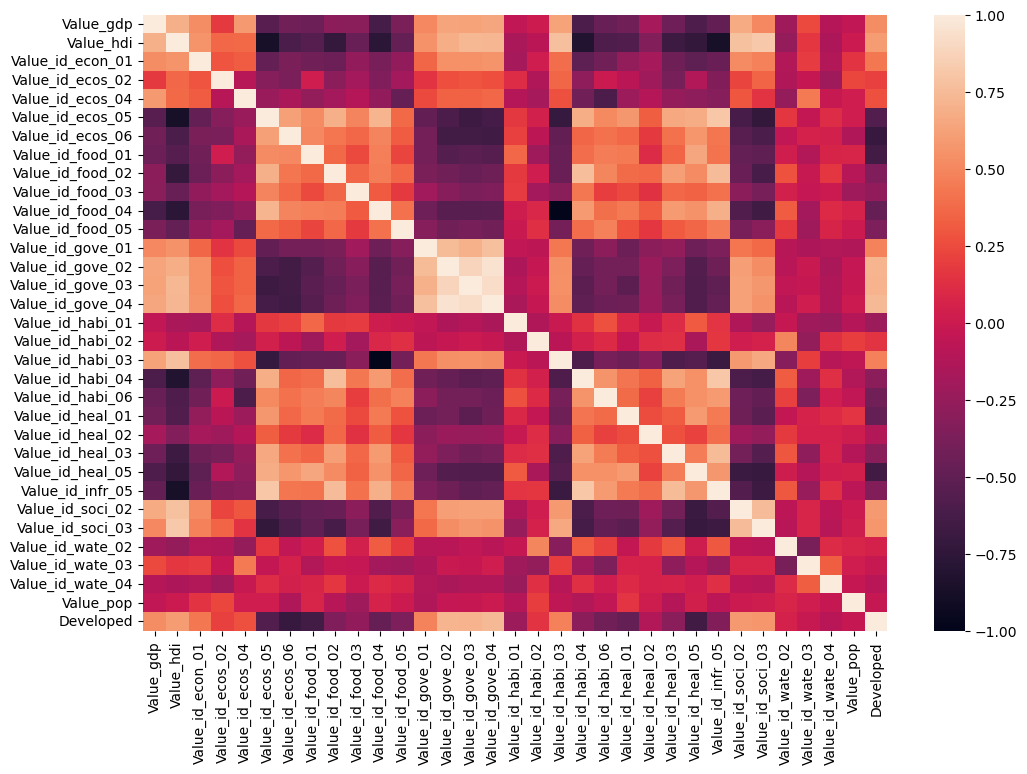

In [136]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(clean_data.corr())

## Classifying developed nations

### PCA Analysis

In [137]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
(clean_data[['Value_gdp','Value_pop']]) = scaler.fit_transform(clean_data[['Value_gdp','Value_pop']])

In [138]:
data_norm = clean_data.drop(['ISO3','Name','Date','Developed'],axis=1)

In [139]:
from sklearn.decomposition import PCA

datapca = PCA().fit(data_norm)
dpcs = datapca.transform(data_norm)
dpcs = pd.DataFrame(dpcs, columns=['PC'+str(i) for i in range(1, dpcs.shape[1]+1)])


In [140]:
dpcs['Developed'] = clean_data['Developed']

Now we can look at how much variance can be explained by each PC, such that when we reduce the dimensionality, we can choose the number of PCs that will maintain most information without going to large dimensions.

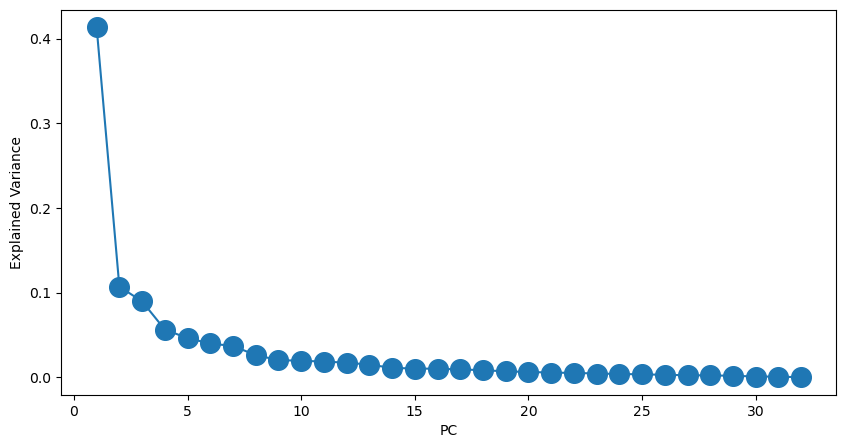

In [141]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1, dpcs.shape[1]), datapca.explained_variance_ratio_)
ax.scatter(range(1, dpcs.shape[1]), datapca.explained_variance_ratio_, s=200)
ax.set_xlabel('PC')
ax.set_ylabel('Explained Variance')
plt.show()



We can also look into the components of the first three PCs

In [142]:
for i in range(0,3):
    for col, comp in zip(data_norm.columns, datapca.components_[i]):
        print(col,':',round(comp,2))
    print('')

Value_gdp : -0.12
Value_hdi : -0.2
Value_id_econ_01 : -0.1
Value_id_ecos_02 : -0.16
Value_id_ecos_04 : -0.08
Value_id_ecos_05 : 0.22
Value_id_ecos_06 : 0.2
Value_id_food_01 : 0.26
Value_id_food_02 : 0.17
Value_id_food_03 : 0.07
Value_id_food_04 : 0.25
Value_id_food_05 : 0.14
Value_id_gove_01 : -0.12
Value_id_gove_02 : -0.2
Value_id_gove_03 : -0.17
Value_id_gove_04 : -0.18
Value_id_habi_01 : 0.04
Value_id_habi_02 : 0.02
Value_id_habi_03 : -0.25
Value_id_habi_04 : 0.18
Value_id_habi_06 : 0.29
Value_id_heal_01 : 0.16
Value_id_heal_02 : 0.07
Value_id_heal_03 : 0.31
Value_id_heal_05 : 0.16
Value_id_infr_05 : 0.36
Value_id_soci_02 : -0.13
Value_id_soci_03 : -0.18
Value_id_wate_02 : 0.05
Value_id_wate_03 : -0.09
Value_id_wate_04 : 0.05
Value_pop : -0.01

Value_gdp : 0.02
Value_hdi : -0.02
Value_id_econ_01 : -0.0
Value_id_ecos_02 : -0.37
Value_id_ecos_04 : 0.16
Value_id_ecos_05 : 0.06
Value_id_ecos_06 : 0.13
Value_id_food_01 : -0.06
Value_id_food_02 : 0.04
Value_id_food_03 : 0.02
Value_id_food

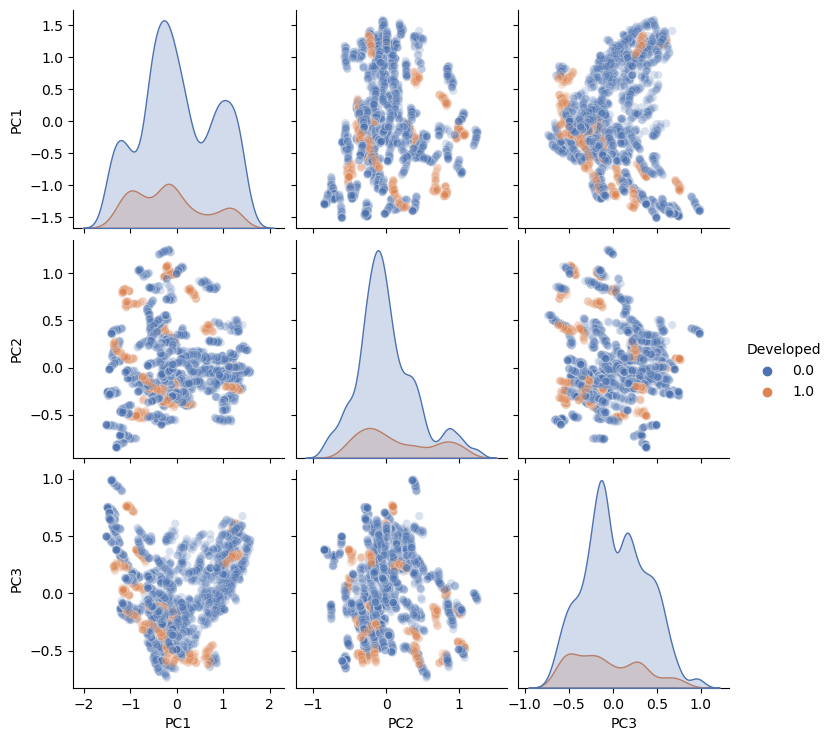

In [143]:
sns.pairplot(data=dpcs, vars=['PC1','PC2','PC3'], hue='Developed',  palette='deep', kind='scatter',plot_kws={'alpha':0.2})

Although it is possible to see some general pattern in the scatter plot to identify developed countries, it is not very clear the separation between developed and undeveloped countries. Because of this, we can also look into supervised learning (Random Forest) to see if we can better classify the data.

### Random Forest

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler

In [188]:
X = clean_data.drop(['ISO3','Name','Date','Developed'],axis=1).values
Y = clean_data['Developed'].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.95)

In [189]:
from sklearn.ensemble import RandomForestClassifier

In [190]:
rfc = RandomForestClassifier(n_estimators=40)
rfc.fit(X_train, Y_train)
rfc_pred = rfc.predict(X_test)

In [191]:
print(confusion_matrix(Y_test,rfc_pred))
print(classification_report(Y_test,rfc_pred))

[[2900    9]
 [  46  553]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2909
         1.0       0.98      0.92      0.95       599

    accuracy                           0.98      3508
   macro avg       0.98      0.96      0.97      3508
weighted avg       0.98      0.98      0.98      3508



We were able to predict correctly the country status according to FMI more than $98\%$ of the time even though we used only 5% of the data to train the model.

### Predicting HDI

Now, we can try predicting HDI based on all other indicators. Here, we use linear regression, as not only it can reproduce all features of the data but it also allows us to understand the relationship between indicators and HDI.

To show how little data we can use to obtain a good fit, we will use a test size of $95\%$ of the dataset.

In [122]:
from sklearn.linear_model import LinearRegression

In [193]:
X = clean_data.drop(['ISO3','Name','Date','Value_hdi','Developed'],axis=1).values
Y = clean_data['Value_hdi'].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.95)

In [194]:
lm = LinearRegression()
lm.fit(X_train,Y_train)

LinearRegression()

In [195]:
coeff_df = pd.DataFrame(lm.coef_,clean_data.drop(['ISO3','Name','Date','Value_hdi','Developed'],axis=1).columns,columns=['Coefficient'])
predictions = lm.predict(X_test)

In [196]:
coeff_df

,Coefficient
Value_gdp,0.217680
Value_id_econ_01,-0.025005
Value_id_ecos_02,-0.002104
Value_id_ecos_04,0.009323
Value_id_ecos_05,-0.105866
Value_id_ecos_06,-0.013794
Value_id_food_01,0.010660
Value_id_food_02,-0.069714
Value_id_food_03,0.007059
Value_id_food_04,-0.000795


Text(0.5, 0, 'Real')

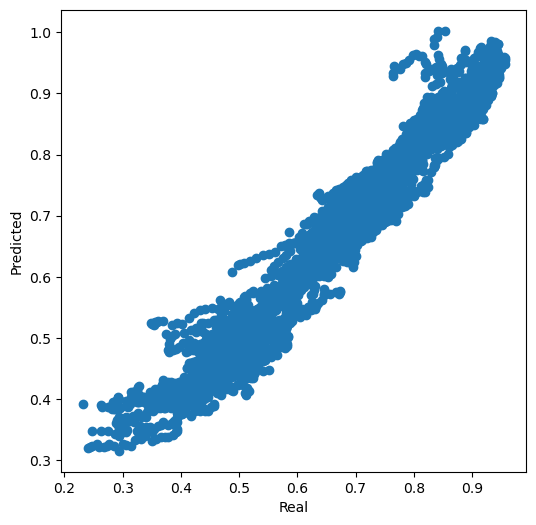

In [203]:
fig, axs = plt.subplots(figsize=(6,6))
plt.scatter(Y_test,predictions)
axs.set_ylabel('Predicted')
axs.set_xlabel("Real")

Text(0.5, 0, 'Error')

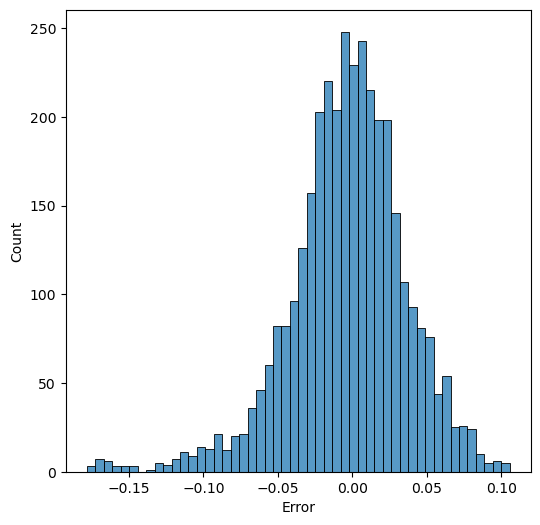

In [202]:
fig, axs = plt.subplots(figsize=(6,6))
sns.histplot((Y_test-predictions),bins=50);
axs.set_xlabel("Error")

To conclude, we can predict the HDI based on all indicators with an error of less than 0.05, which considering the amount of data used is good and shows the linear relationship between the economic, social and environmental indicators with HDI.